In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

In [3]:
#first step we want to read the csv files we have 2 in this case one for training and one
#for testing

train_df=pd.read_csv('/Users/ahmadkheir/Desktop/dev/python/titanic_survivors(supervised)/Titanic-Dataset.csv')
test_df=pd.read_csv('/Users/ahmadkheir/Desktop/dev/python/titanic_survivors(supervised)/titanic_test.csv')

#now we want to create a copy to leave the original df untouched if we want to reload.

train_working=train_df.copy(deep=True)
test_working=test_df.copy(deep=True)



In [36]:
print("train coloumns:",list(train_df.columns))
print("test columns:",list(test_df.columns))

train coloumns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
test columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [9]:
print(train_working['Survived'].value_counts())
print(train_working['Survived'].value_counts(normalize=True).round(3))

Survived
0    549
1    342
Name: count, dtype: int64
Survived
0    0.616
1    0.384
Name: proportion, dtype: float64


/var/folders/zr/1xsx35t50_54f5178pnht0580000gn/T/ipykernel_33305/2469521638.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Sex",y="Survived",data=train_working,ci=None)


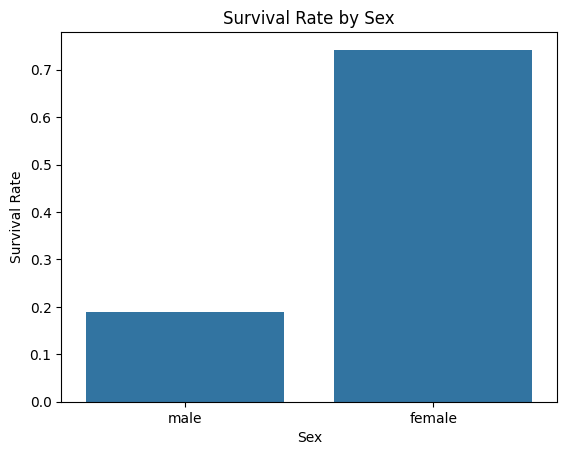

/var/folders/zr/1xsx35t50_54f5178pnht0580000gn/T/ipykernel_33305/2469521638.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Pclass", y="Survived", data=train_working, ci=None)


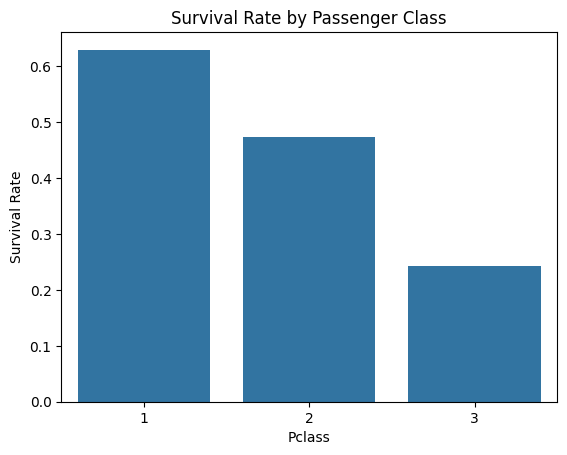

/var/folders/zr/1xsx35t50_54f5178pnht0580000gn/T/ipykernel_33305/2469521638.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Age_group", y="Survived", data=train_working, ci=None)


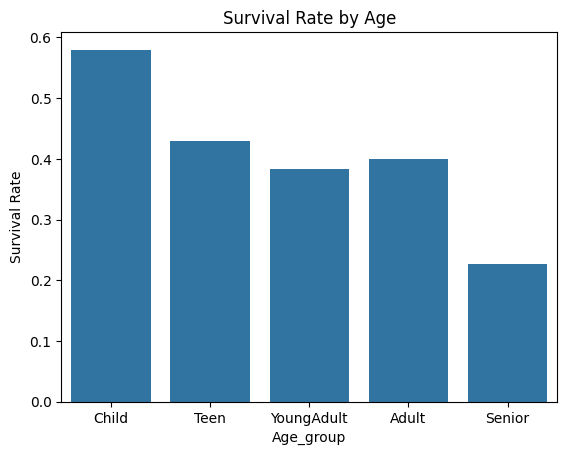

/var/folders/zr/1xsx35t50_54f5178pnht0580000gn/T/ipykernel_33305/2469521638.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Fare_range",y="Survived",hue="Age_group",data=train_working,ci=None)


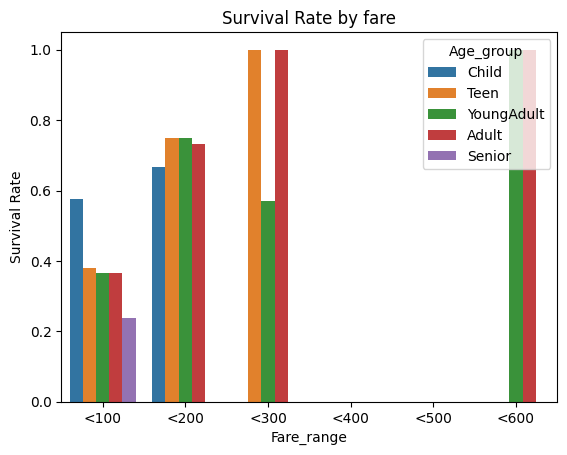

/var/folders/zr/1xsx35t50_54f5178pnht0580000gn/T/ipykernel_33305/2469521638.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Embarked",y="Survived",hue="Pclass",data=train_working,ci=None)


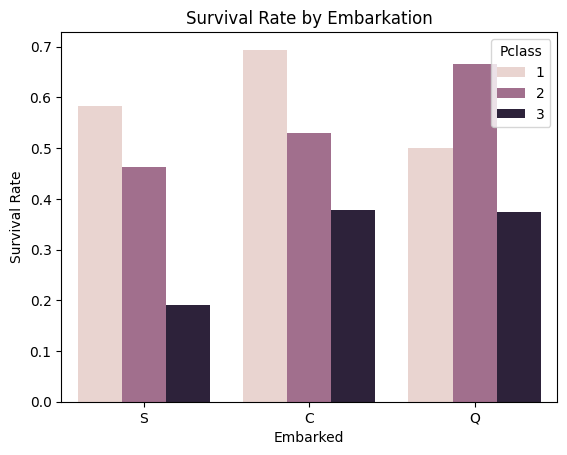

In [32]:

sns.barplot(x="Sex",y="Survived",data=train_working,ci=None)
plt.title("Survival Rate by Sex")
plt.ylabel("Survival Rate")
plt.show()

sns.barplot(x="Pclass", y="Survived", data=train_working, ci=None)
plt.title("Survival Rate by Passenger Class")
plt.ylabel("Survival Rate")
plt.show()

age_bins=[0,12,18,35,60,80]
age_labels = ["Child", "Teen", "YoungAdult", "Adult", "Senior"]
train_working['Age_group']=pd.cut(train_working['Age'],bins=age_bins,labels=age_labels)
sns.barplot(x="Age_group", y="Survived", data=train_working, ci=None)
plt.title("Survival Rate by Age")
plt.ylabel("Survival Rate")
plt.show()
fare_bins=[0,100,200,300,400,500,600]
fare_labels=["<100","<200","<300","<400","<500","<600"]
train_working['Fare_range']=pd.cut(train_working["Fare"],bins=fare_bins,labels=fare_labels)
sns.barplot(x="Fare_range",y="Survived",hue="Age_group",data=train_working,ci=None)
plt.title("Survival Rate by fare")
plt.ylabel("Survival Rate")
plt.show()

sns.barplot(x="Embarked",y="Survived",hue="Pclass",data=train_working,ci=None)
plt.title("Survival Rate by Embarkation")
plt.ylabel("Survival Rate")
plt.show()

In [40]:
#handle the missing values



#droping the cols used for ploting purposes in the step above

train_working=train_working.drop(columns=["Age_group","Fare_range","Cabin"],errors="ignore")


In [42]:
print("Train columns now:", train_working.columns.tolist())
train_working.isna().sum()

Train columns now: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

In [45]:

test_working=test_working.drop(columns=["Cabin"],errors="ignore")

In [46]:
test_working.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64

In [ ]:
#we want to do feature engineering to get the title from the name to fill the age
#in a correct way instead of using the median
train_working["Title"] = train_working["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)
test_working["Title"]  = test_working["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)



In [50]:
print(train_working['Title'].unique())
print(train_working["Title"].value_counts())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


In [51]:
title_replacements={
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Lady": "Other",
    "the Countess": "Other",
    "Capt": "Other",
    "Col": "Other",
    "Don": "Other",
    "Dr": "Other",
    "Major": "Other",
    "Rev": "Other",
    "Sir": "Other",
    "Jonkheer": "Other"
}

train_working["Title"] = train_working["Title"].replace(title_replacements)
test_working["Title"]=test_working["Title"].replace(title_replacements)


In [52]:
print(train_working["Title"].value_counts())

Title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64


In [56]:
#now we have made the title columns without unique values we need to start filling
# the missing values in the age column

#train_working['Age'].info()#to check they are numbers before we work 
#test_working['Age'].info()

title_age_median=train_working.groupby("Title")["Age"].median()
print(title_age_median.tolist())

[3.5, 21.0, 30.0, 35.0, 48.5]


In [57]:
global_age_median_train = train_working["Age"].median()
global_age_median_test  = test_working["Age"].median()

print(global_age_median_test,global_age_median_test)

27.0 27.0


In [64]:
#now we want to fill the missing values in the age column
train_working["Age"]=train_working["Age"].fillna(
    train_working["Title"].map(title_age_median)
)
test_working["Age"]=test_working["Age"].fillna(
    test_working["Title"].map(title_age_median)
)
test_working["Age"] = test_working["Age"].fillna(global_age_median_train)

In [66]:
print("Remaining missing  in train:", train_working.isna().sum())
print("Remaining missing  in test:",  test_working.isna().sum())

Remaining missing  in train: PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Title          0
dtype: int64
Remaining missing  in test: PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Title          0
dtype: int64


In [71]:
#in the embarked column we have only 2 missing values so we decide to replace it by the 
#most frequent values

embarked_mode=train_working["Embarked"].mode()[0]
train_working["Embarked"] = train_working["Embarked"].fillna(embarked_mode)
print("Remaining missing  in train:", train_working.isna().sum())


Remaining missing  in train: PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64


In [72]:
#now we want to fill the fare in the testing dataset

fare_median_train = train_working["Fare"].median()

# Fill missing Fare in test
test_working["Fare"] = test_working["Fare"].fillna(fare_median_train)

print("\nRemaining missing values in test:\n", test_working.isna().sum())


Remaining missing values in test:
 PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64


In [75]:
# Columns to drop
cols_to_drop = ["PassengerId", "Name", "Ticket"]

# Drop them from train and test working copies
train_features = train_working.drop(columns=cols_to_drop + ["Survived"])#input X
test_features  = test_working.drop(columns=cols_to_drop)

# Keep the target variable separately from train
train_target = train_working["Survived"]#output y

print("Training features:", train_features.columns.tolist())
print("Testing features:", test_features.columns.tolist())
print("Target shape:", train_target.shape)


Training features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']
Testing features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']
Target shape: (891,)


In [79]:
#now we want to check the datatype for each columns
print("training \n",train_features.dtypes)
print("testing \n",test_features.dtypes)


training 
 Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
Title        object
dtype: object
testing 
 Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
Title        object
dtype: object


In [82]:
numeric_features = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_features = ["Sex", "Embarked", "Title"]

#Preprocessing pipelines

numeric_transformer=Pipeline(steps=[
    ("imputer ",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))#to ignore unseen data and don't crash
])

preprocess=ColumnTransformer(
    transformers=[
        ("num",numeric_transformer,numeric_features),
        ("cat",categorical_transformer,categorical_features)
    ]
)

'''stratify=train_target: keeps the survival class ratio similar 
in both splits (important with imbalance).'''

X_train, X_valid, y_train, y_valid = train_test_split(
    train_features,
    train_target,
    test_size=0.2,
    stratify=train_target,
    random_state=42
)



In [88]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}
scoring=["accuracy","f1"]
for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    for method in scoring:
      scores = cross_val_score(clf, train_features, train_target, cv=5, scoring=method)
      print(f"{name}: Mean {method}={scores.mean():.3f}, Std={scores.std():.3f}")


Logistic Regression: Mean accuracy=0.829, Std=0.023
Logistic Regression: Mean f1=0.772, Std=0.039
Random Forest: Mean accuracy=0.800, Std=0.028
Random Forest: Mean f1=0.731, Std=0.046
XGBoost: Mean accuracy=0.818, Std=0.021
XGBoost: Mean f1=0.756, Std=0.031


In [92]:
#we will choose the logistic regression as our model

final_clf = Pipeline([
    ("preprocess", preprocess),              # your ColumnTransformer
    ("model", LogisticRegression(max_iter=1000))
])


final_clf.fit(train_features,train_target)

test_pred = final_clf.predict(test_features)

submission = pd.DataFrame({
    "PassengerId": test_working["PassengerId"],   # original PassengerId from test
    "Survived": test_pred
})



In [93]:
print(submission.head(15))

    PassengerId  Survived
0           892         0
1           893         1
2           894         0
3           895         0
4           896         1
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0
11          903         0
12          904         1
13          905         0
14          906         1


In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, train_target,
    test_size=0.2, stratify=train_target, random_state=42
)

# Baseline pipeline = your preprocess + logistic regression
baseline_clf = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

baseline_clf.fit(X_train, y_train)
y_pred_valid = baseline_clf.predict(X_valid)

base_acc = accuracy_score(y_valid, y_pred_valid)
print(f"Baseline validation accuracy: {base_acc:.3f}")

Baseline validation accuracy: 0.838


In [98]:
param_grid = [
    {   # lbfgs supports only L2
        "model__solver": ["lbfgs"],
        "model__penalty": ["l2"],
        "model__C": [0.01, 0.1, 0.5, 1, 2, 5, 10],
        "model__class_weight": [None, "balanced"],
    },
    {   # liblinear supports L1 and L2
        "model__solver": ["liblinear"],
        "model__penalty": ["l1", "l2"],
        "model__C": [0.01, 0.1, 0.5, 1, 2, 5, 10],
        "model__class_weight": [None, "balanced"],
    },
]

grid = GridSearchCV(
    Pipeline([("preprocess", preprocess),
              ("model", LogisticRegression(max_iter=1000, random_state=42))]),
    param_grid=param_grid,
    scoring="accuracy",   # optimize accuracy as you requested
    cv=5,
    n_jobs=-1
)

# Fit the grid on TRAIN ONLY (no peeking at X_valid)
grid.fit(X_train, y_train)

print("Best CV accuracy (mean over folds):", f"{grid.best_score_:.3f}")
print("Best params:", grid.best_params_)

# Evaluate the tuned model on the same hold-out for a fair comparison
best_clf = grid.best_estimator_
tuned_acc = accuracy_score(y_valid, best_clf.predict(X_valid))
print(f"Tuned validation accuracy: {tuned_acc:.3f}")

improvement = tuned_acc - base_acc
print(f"Improvement over baseline: {improvement:+.4f}")


Best CV accuracy (mean over folds): 0.824
Best params: {'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Tuned validation accuracy: 0.838
Improvement over baseline: +0.0000


In [99]:
submission.to_csv("submission.csv", index=False)